# Brain tumor segmentation
* MRI images
* U-Net

In [1]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

## Exploring data

In [59]:
# utils
image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")


def list_images(base_path,contains=None):
    # return the set of files that are valid
    return list_files(base_path, valid_exts=image_types, contains=contains)

def list_files(base_path, valid_exts=None, contains=None):
    # loop over the directory structure
    for root_dir, _, filenames in os.walk(base_path):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if valid_exts is None or ext.endswith(valid_exts):
                # construct the path to the image and yield it
                image_path = os.path.join(root_dir, filename)
                yield image_path

In [63]:
DATA_PATH = "C:\\Users\\camil\\Documents\\code\\segmentation_brain\\data\\kaggle_3m"

In [65]:
image_paths=list(list_images(DATA_PATH))

dataset=pd.DataFrame(image_paths, columns=['filepath'])

print(dataset['filepath'][0])
print(dataset['filepath'].iloc[-1])

C:\Users\camil\Documents\code\segmentation_brain\data\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_1.tif
C:\Users\camil\Documents\code\segmentation_brain\data\kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61B_19991127_9_mask.tif


In [98]:
# Select "images" and "masks"
images=dataset[~dataset["filepath"].str.contains("mask")]
masks=dataset[dataset["filepath"].str.contains("mask")]

# sort images by n
base_len=len('C:\\Users\\camil\\Documents\\code\\segmentation_brain\\data\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_')
img_len=len('.tif')
mask_len=len('_mask.tif')

images=sorted(images.filepath.values,key=lambda p : int(p[base_len:-img_len]))
masks=sorted(masks.filepath.values,key=lambda p : int(p[base_len:-mask_len]))
print(images[0])
print(masks[0])

C:\Users\camil\Documents\code\segmentation_brain\data\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_1.tif
C:\Users\camil\Documents\code\segmentation_brain\data\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_1_mask.tif


In [70]:
patients=[i.split('\\')[8] for i in images]
print(patients[0])

TCGA_CS_4941_19960909


In [101]:
def diagnosis(path):
    
    value = np.max(cv2.imread(path))
    if value > 0 : return 1 # Mask with a region of ones the diagnosis is 1
    else: return 0 # Mask without a region of ones the diagnosis is 0
    
dataset=pd.DataFrame({
    "patient": patients,
    "image_path":images,
    "mask_path": masks,
})

dataset["diagnosis"]=dataset["mask_path"].apply(lambda path:diagnosis(path))
print("Number of negative (0) and positive (1) cases:")
print(dataset.diagnosis.value_counts())

Number of negative (0) and positive (1) cases:
0    2556
1    1373
Name: diagnosis, dtype: int64


In [106]:
dataset[dataset['diagnosis']==1].head()

,patient,image_path,mask_path,diagnosis
444,TCGA_CS_5393_19990606,C:\Users\camil\Documents\code\segmentation_bra...,C:\Users\camil\Documents\code\segmentation_bra...,1
522,TCGA_HT_7680_19970202,C:\Users\camil\Documents\code\segmentation_bra...,C:\Users\camil\Documents\code\segmentation_bra...,1
553,TCGA_CS_4944_20010208,C:\Users\camil\Documents\code\segmentation_bra...,C:\Users\camil\Documents\code\segmentation_bra...,1
554,TCGA_CS_5393_19990606,C:\Users\camil\Documents\code\segmentation_bra...,C:\Users\camil\Documents\code\segmentation_bra...,1
628,TCGA_HT_7602_19951103,C:\Users\camil\Documents\code\segmentation_bra...,C:\Users\camil\Documents\code\segmentation_bra...,1


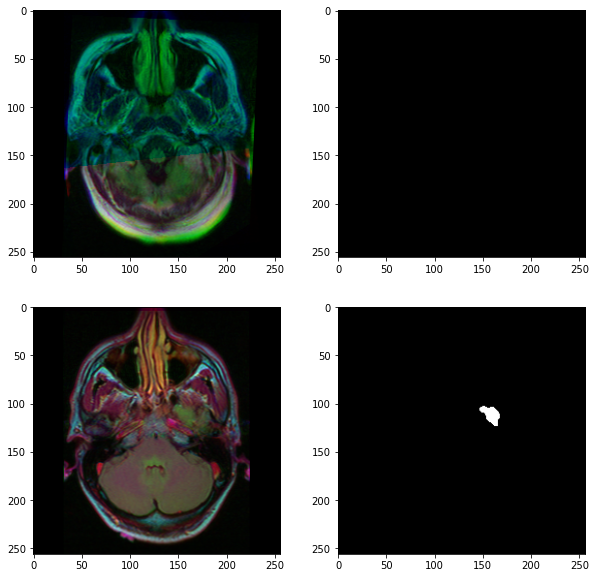

In [135]:
fig,ax=plt.subplots(2,2,figsize=(10, 10))

img1=cv2.imread(dataset['image_path'][5])
mask1=cv2.imread(dataset['mask_path'][5])
ax[0,0].imshow(img1)
ax[0,1].imshow(mask1)

img2=cv2.imread(dataset['image_path'][444])
mask2=cv2.imread(dataset['mask_path'][444])
ax[1,0].imshow(img2)
ax[1,1].imshow(mask2)

### U-Net definition